In [15]:
import numpy as np
import matplotlib.pyplot as plt
import argparse
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Input, Conv2D, UpSampling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, DirectoryIterator

from model_training import create_model, prepare_images
from PIL import Image
from tensorflow.keras.preprocessing.image import array_to_img
from matplotlib.pyplot import imshow
%matplotlib inline

Variabili Globali dei Path del modello e del Validation Set

In [3]:
MODEL_PATH      = './deep_undeeper224.model' # path del modello allenato
VALIDATION_PATH = './ilsvrc2012Validation'   # path del dataset di validazione (1001 imgs)

Carico il modello gia' allenato

In [4]:
model = create_model()                      # creo il modello
model = keras.models.load_model(MODEL_PATH) # carico il modello allenato

Riassunto del modello

In [5]:
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 512)     14336     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 512)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 512)     2048      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 256)     1179904   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 256)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 56, 56, 256)       1024  

Perparo le immagini di Validazione per essere passate al modello.
Imposto il parametro `shuffle=False` per evitare che le immagini vengano mischiate ogni volta e quindi per averle nello stesso ordine di come si trovano nella cartella.

In [6]:
validation :DirectoryIterator = prepare_images(VALIDATION_PATH, shuffle=False)

Found 1001 images belonging to 1 classes.


Effettuo la fase di Evaluation per verificare il valore Loss

In [7]:
result_eval = model.evaluate(validation)
print(f'\nLoss: {result_eval} ({model.metrics_names})')

126/126 [==============================] - 11s 61ms/step - loss: 0.0042

Loss: 0.004245703108608723 (['loss'])


Definisco la funzione che mi permettera' di convertire il `DirectoryIterator` in un `numpy.array` per effettuare piu' facilmente le operazioni successive sulle varie immagini.

In [8]:
def dirIterator_to_array(iter: DirectoryIterator) -> np.array:
    """ Converte un DirectoryIterator in numpy.arry

        Parameters:
            iter (DirectoryIterator): DirectoryIterator da trasformare in array
        
        Return:
            numpy.array: array con tutte le immagini generate da DirectoryIterator
    """
    
    data_list = []
    batch_index = 0

    while batch_index <= iter.batch_index:
        data = iter.next()
        tmp = data[0]
        for elem in tmp:
            data_list.append(elem)

        batch_index = batch_index + 1

    data_array = np.array(data_list)

    return data_array

Trasformo il `DirectoryIterator` in `numpy.arry` e prendo tutti i nomi delle immagini.

I nomi delle immagini hanno lo stesso ordine delle immagini effettive:
    
* `validation_names[i]` corrispondera' al nome della foto `validation_np[i]`

In [9]:
validation_np    :np.array = dirIterator_to_array(validation) # trasforma DirectoryIterator in np.arry
validation_names :np.array = np.array(validation.filenames)   # prende i nomi di tutte le immaigni

Passo al modello le immagini di Validazione

In [11]:
result_predict :np.array = model.predict(validation)

Stampo le prime 15 immagini per effettuare un confronto tra quelle originali e quelle ricostruite dal modello

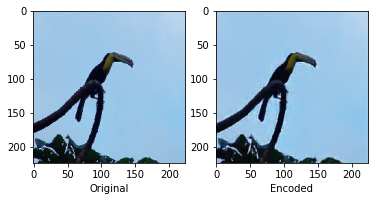

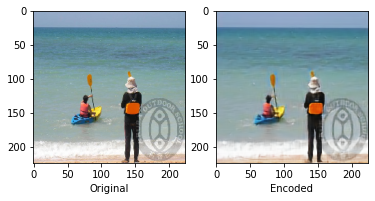

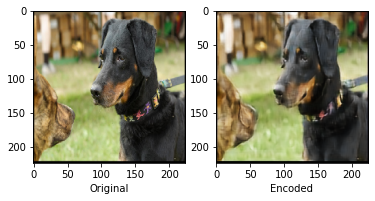

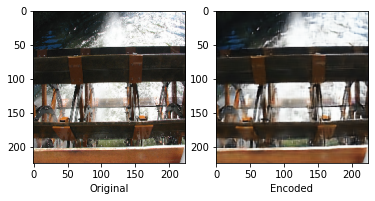

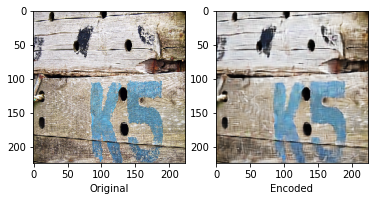

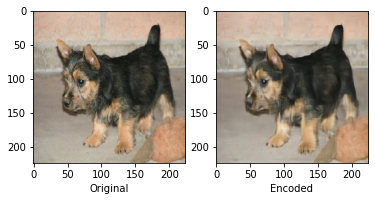

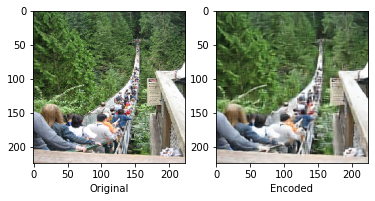

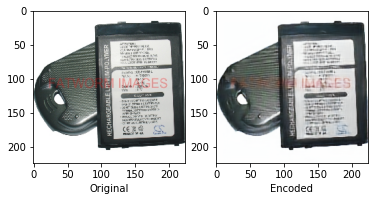

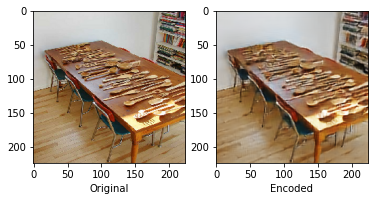

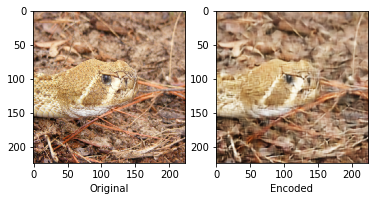

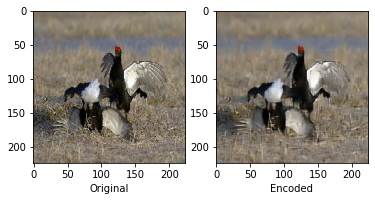

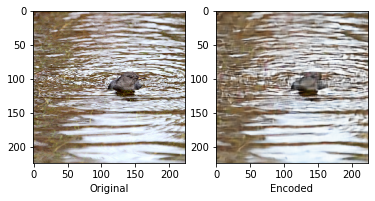

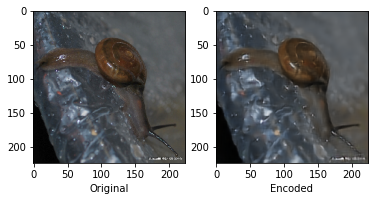

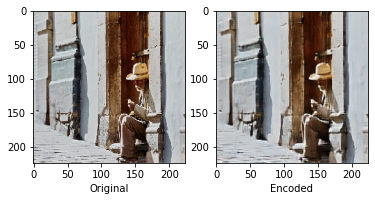

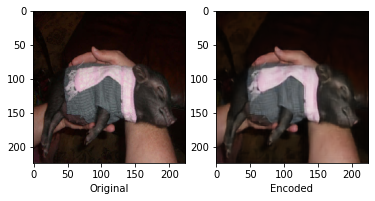

In [37]:
for i in range(15):
    f, axarr = plt.subplots(1,2) 
    # print(dir(axarr[0]))
    axarr[0].set_xlabel('Original')
    axarr[0].imshow(validation_np[i])
    
    axarr[1].set_xlabel('Encoded')
    axarr[1].imshow(result_predict[i])


Calcolo l'errore di ricostruzione per ogni immagine e trovo le immagini 'distorte' e quelle 'pulite'

In [38]:
errori          = np.array([])  # array con i risultati finali
conta_distorta  = 0             # immagine non appartenenti al dataset di origine
conta_pulita    = 0             # immagini appartenenti al dataset di origine
treshold        = 0.87          # treshold di attivazione per considerare un'immagine pulita (<= treshold) o distorata (> treshold)
i               = 0             # contatore per accedere alle posizioni dei 2 array

for i in range(len(validation_np)):
    errore = (np.square(validation_np[i] - result_predict[i])).mean()   # calcola l'errore (??)
    errore = errore * 100
    errori = np.append(errori, errore)

    # conta quante sono le immagini considerate 'distorte' e quelle 'pulite'
    if errore > treshold :
        conta_distorta += 1
    else:
        conta_pulita += 1

print('')
print(f"immagini pulite = {conta_pulita} ({conta_pulita/len(validation_np)*100}%)")
print(f"immagini distorte =  {conta_distorta} ({conta_distorta/len(validation_np)*100}%)")
print(f"media errore dataset = {np.mean(errori)}")


immagini pulite = 879 (87.81218781218782%)
immagini distorte =  122 (12.187812187812188%)
media errore dataset = 0.4245702447332479


Creo una classe per contenere i dati delle singole immagini:
    
* nome
* errore
* immagine stessa

In [64]:
class ImgData:
    def __init__(self, name: str, data: np.array, errore: float):
        self.name = name
        self.data = data
        self.errore = errore
    
    def __repr__(self):
        return f'{self.name},{self.errore}'

Creo una lista con gli oggetti che rappresentano le immagini di Validazione e le ordino in base all'errore

In [78]:
imgs = []

for i in range(len(validation_np)):
    imgs.append(ImgData(validation_names[i], validation_np[i], errori[i]))

def get_my_key(obj):
    return obj.errore

imgs.sort(key=get_my_key)

Stampo i nomi delle immagini con i relativi errori

In [ ]:
for img in imgs:
    print(str(img).replace(',', '\t'))

Stampo a video il grafico degli errori delle immagini di Validazione

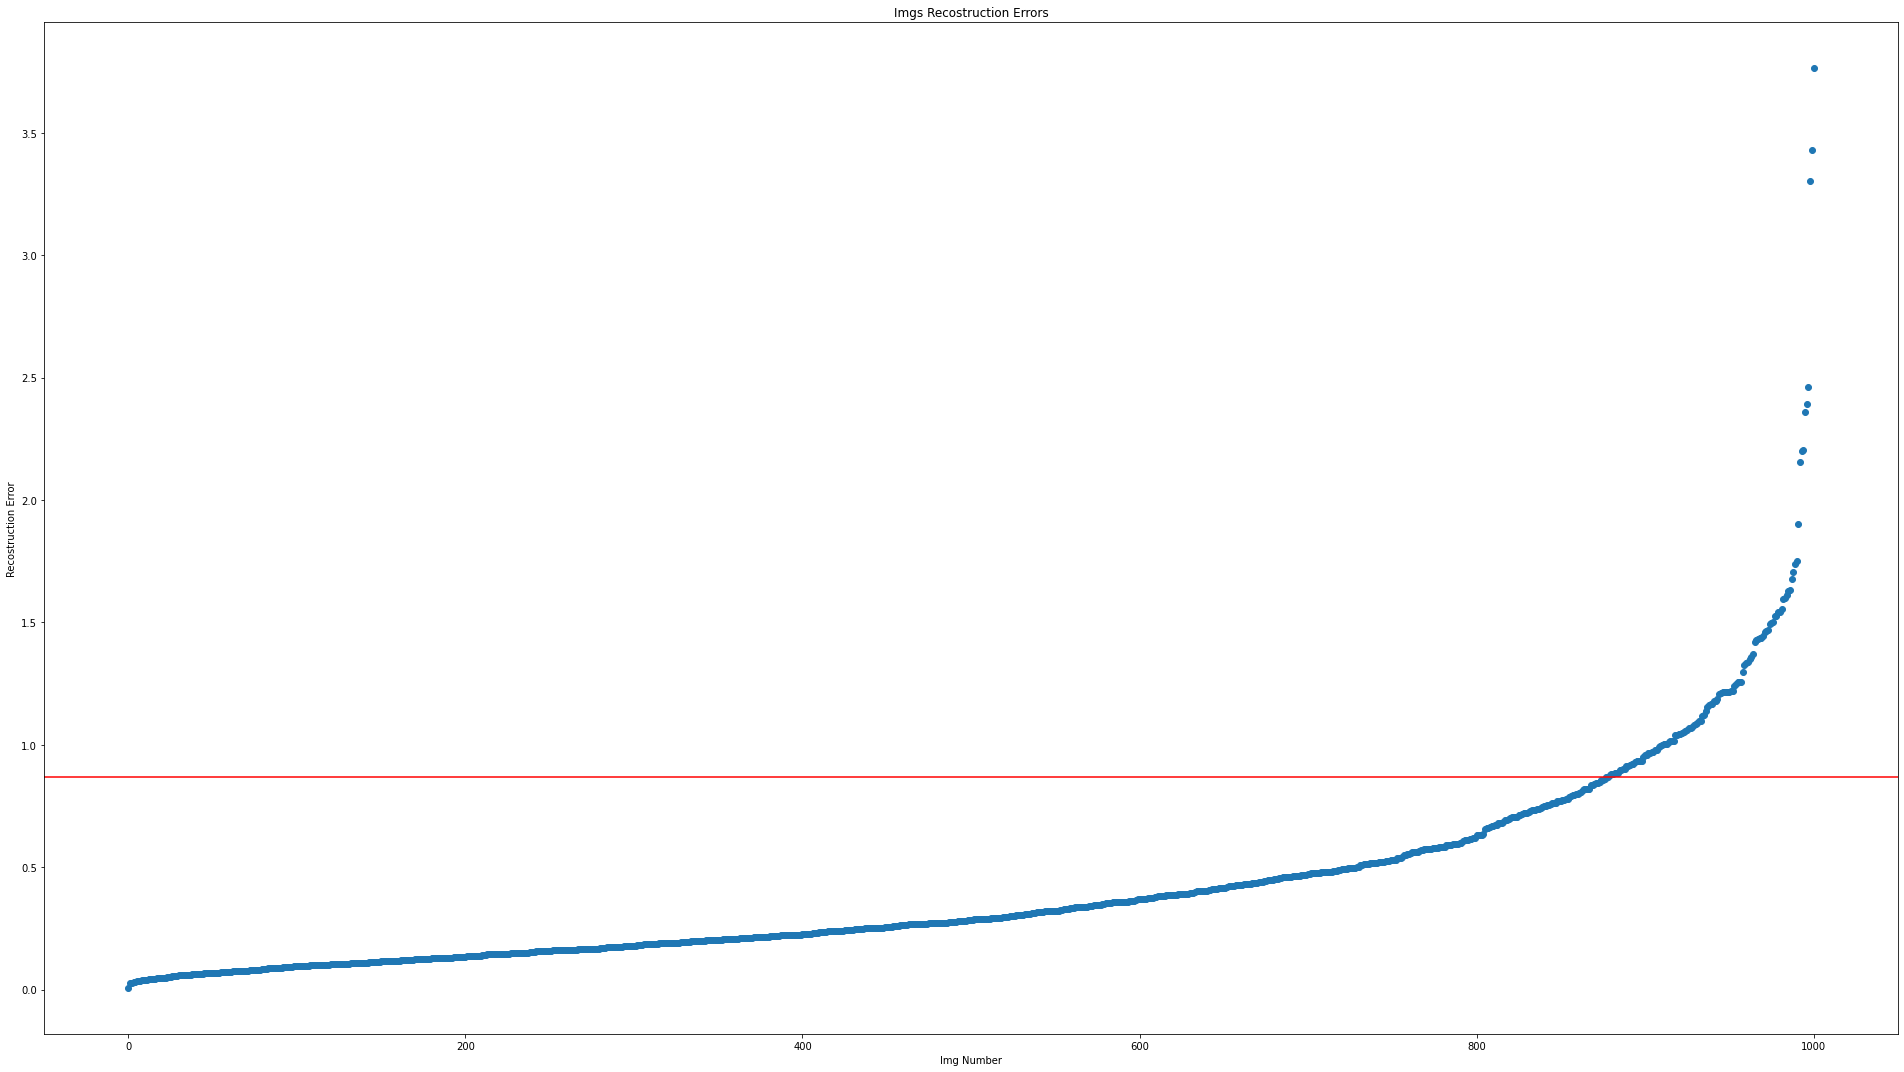

In [86]:
x = np.array(range(len(validation_sorted))) # ad ogni immagine associo un numero crescente
y = np.array([x.errore for x in imgs])      # ottengo solo l'errore dagli oggetti

px = 1/plt.rcParams['figure.dpi']       # pixel in inches
plt.figure(figsize=(1920*px, 1080*px))  # dimensione della figura

# setto le varie scritte da aggiungere al grafico
plt.title('Imgs Recostruction Errors')
plt.xlabel('Img Number')
plt.ylabel('Recostruction Error')

plt.tight_layout()
plt.scatter(x, y)                       # stampa gli errori delle immagini
plt.axhline(y=0.87, color='red')        # stampa la linea della treshold

plt.savefig('errori_chart_sorted.png', dpi=300)    # stampa il grafico ad alta risoluzione
